In [132]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [133]:
model_path = "C:/Users/allan/PycharmProjects/FacialAttributeClassifier/Models/Epoch9.h5"

In [134]:
classifier = tf.keras.models.load_model(model_path)

In [135]:
def plot_image(tensor):
    plt.imshow(tensor)
    plt.show()

In [136]:
def center_crop(img):
    #Get the 2 dimensions
    dim1 = img.shape[0]
    dim2 = img.shape[1]

    #Get the smaller dim
    smaller_dim = min(dim1, dim2)

    #Get the center for both dimensions
    dim1_center = dim1 // 2
    dim2_center = dim2 // 2

    #Crop from center for both dimensions
    dim1_start = dim1_center-smaller_dim//2
    dim1_end = dim1_center+smaller_dim//2

    dim2_start = dim2_center-smaller_dim//2
    dim2_end = dim2_center+smaller_dim//2

    img = img[dim1_start:dim1_end, dim2_start:dim2_end, :]
    return img

In [137]:
def preprocess_image(path):
    #Read the image
    image_file = tf.io.read_file(path)
    #Convert it to a tensor
    image_tensor = tf.image.decode_png(image_file)
    #Select the correct channels
    image_tensor = image_tensor[:,:,:3]
    #Center crop it
    image_tensor = center_crop(image_tensor)
    #Cast it to float32
    image_tensor = tf.cast(image_tensor, tf.float32)
    #Scale it
    image_tensor = image_tensor/255.
    #Resize it
    image_tensor = tf.image.resize(image_tensor, (128, 128), method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
    #Expand dims
    image_tensor = tf.expand_dims(image_tensor, axis = 0)
    return image_tensor


In [138]:
#Need an input image
test_image_path = "C:/Users/allan/Downloads/GANFacesDateset/seed0001.png"
#Initialize a loss function
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [139]:
with tf.GradientTape() as tape:
    #Preprocess it to input it into model
    image_tensor = preprocess_image(test_image_path)
    saved_image_tensor = image_tensor[0]
    tape.watch(image_tensor)
    actual_prediction = classifier(image_tensor)
    expected_prediction = tf.ones_like(actual_prediction)
    loss = loss_function(y_true = expected_prediction, y_pred = actual_prediction)
    gradient = tape.gradient(loss, image_tensor)

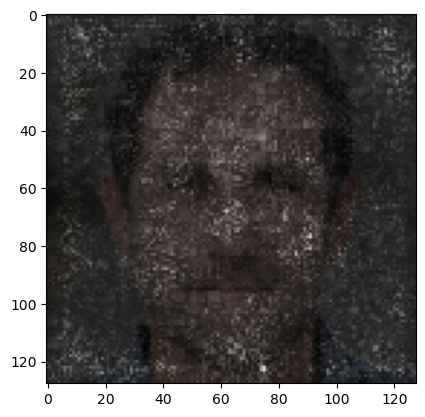

In [140]:
#Remove the unneeded dimension
gradient = tf.squeeze(gradient)
#Collapse the 3 channels
gradient = tf.abs(gradient)
gradient = tf.reduce_sum(gradient, axis = -1)
#Scale it from 0 to 1
grayscale_tensor = (gradient - tf.reduce_min(gradient))/(tf.reduce_max(gradient) - tf.reduce_min(gradient))
#Give the grayscale tensor a channel to be comparable to the input image
grayscale_tensor = tf.expand_dims(grayscale_tensor, axis = -1)
alpha = 0.8
combined_image = alpha * grayscale_tensor + (1 - alpha) * saved_image_tensor

plt.imshow(combined_image)
plt.show()